## Introduction
Capturing sentiment in language is important in these times where decisions and reactions are created and updated in a matter of time. A single tweet, once it gets viral, can make an extreme impact on any company’s revenue. But if one can figure that out well ahead, a devastating loss can be prevented. But what are the words that actually lead to the sentiment description? Extraction of texts which determines the sentiment can also benefit the organization in the following ways:
- Become more competitive
- Attract new customers
- Retain present customers
- Sell more products and services
- Reduce customer servicing
- Make customers more profitable
- Improve marketing messages and campaigns

In this project, we will be picking out the part of the tweet (word or phrase) that reflects the sentiment.

## Import Libraries

In [1]:
import numpy as np # To work with numpy arrays and algebra 
import pandas as pd # To work with dataframes
import matplotlib.pyplot as plt # To plot the figures
import seaborn as sns # To plot the figures
import nltk # To work with natural language
from zipfile import ZipFile # To extract the zip file
from nltk.corpus import stopwords
import re # To clean the tweets
import cv2
import string
from wordcloud import WordCloud # To buld the word clouds
import tensorflow as tf 
import tensorflow.keras.backend as k # To implement custom loss
from tensorflow.keras.preprocessing.text import Tokenizer # To tokenize the tweets
from tensorflow.keras.preprocessing.sequence import pad_sequences # To make tokenize sequence length equal
from tensorflow.keras.models import Sequential # Sequential Model
from tensorflow.keras.regularizers import l2 # L2 regularization
from tensorflow.keras.layers import RNN, LSTM, Bidirectional, Embedding, GRU, GlobalAveragePooling1D, Conv1D, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam # Optimizer
from sklearn.model_selection import train_test_split # To split the dataset
from tensorflow.keras.models import load_model # to load saved model

## Data Path

In [2]:
DATA_PATH = r'C:\Users\14372\Downloads\Compressed\twitter' # Data Path

## Extracting Zip file

In [3]:
def zipreader(path):
    """This function extracts zipfile from the given path
    Input: File's path
    Returns: Nothing"""
    
    path = path + '.zip'
    with ZipFile(path, 'r') as z:
        print('Extracting zipfile... ')
        z.extractall(r'C:\Users\14372\Downloads\Compressed') #Extracting Zipfile
        print('Extraction Done.')

In [4]:
zipreader(DATA_PATH)

Extracting zipfile... 
Extraction Done.


## Reading Data

In [5]:
orig_df = pd.read_csv( 'train.csv', delimiter= ',') #Reading CSV file
orig_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
df = orig_df.copy() #to make a copy

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Observations:
1. There are 27481 total instances
2. There is an instance, where the text and textID features are null.

## Data Insights

In [8]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,affb92192f,grats to aaron and christine,good,neutral
freq,1,1,199,11118


In [9]:
df[df['selected_text'].duplicated()]['selected_text'].value_counts().head() # duplicated selected_text

good     198
love     184
Happy    162
miss     142
happy    105
Name: selected_text, dtype: int64

### Count Plot

<AxesSubplot:xlabel='sentiment', ylabel='count'>

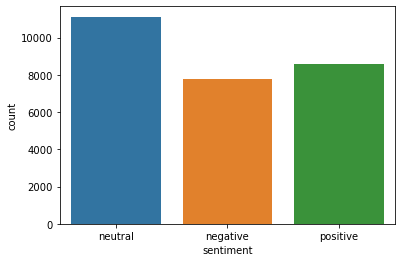

In [10]:
sns.countplot(x = df['sentiment'])

In [11]:
df.groupby('sentiment').count()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11118,11117,11117
positive,8582,8582,8582


Observations:
1. Out of 27481 instances, there are 7781 negative, 11118 neutral, and 8582 positive tweets.

## Data Preprocessing

### Null/Missing Values

<AxesSubplot:>

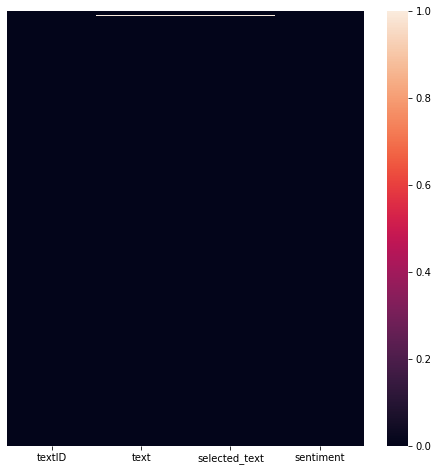

In [12]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.isnull(), yticklabels=False) # Heatmap for visualising null values

Observations:
1. There are 27481 total instances
2. There is an instance, where the text and textID features are null.

### Dropping Null Values

In [13]:
df.dropna(inplace=True) # Dropping Null values
orig_df.dropna(inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


Observations:
1. Now, there are no null values.

### Dropping TextID

In [15]:
df = df.iloc[:, 1:]
orig_df.drop('textID', inplace=True, axis = 1)

In this project, we are not using TextID, hence this column is dopped.

### Jaccard Similarity Score

In [17]:
def image(path, title):
    """To show image from path with title"""
    
    try: 
        img = cv2.imread(path)
        plt.axis('off')
        plt.title(title)
        plt.imshow(img)
    except:
        print('Image Not Found ')

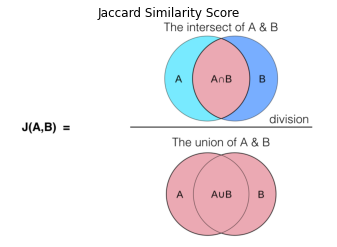

In [18]:
image(path = r'C:\Users\14372\Desktop\College-2\CAPstone\PROJECT\Jaccardi.png', title='Jaccard Similarity Score')

In [19]:
def jaccard_score(str1, str2):
    """This function calculate jaccard similarity score for two strings
    Input: Two strings
    Return: jaccard similarity score
    """
    
    l1, l2, l3 = set(), set(), set() # Three empty sets
    
    l1 = set(str1.strip().lower().split()) # converting list of words in string 1 to set
    l2 = set(str2.strip().lower().split()) # converting list of words in string 2 to set
    l3 = l1.intersection(l2) # Finding common words in both strings
    
    d = (len(l1) + len(l2) - len(l3)) # Number of words in union of l1 and l2
    
    if d <= 0: # In preprocessing, if all words are removed
        score = np.nan
    else:
        score = len(l3) / d # jaccard similarity score
    
    return score

In [20]:
jaccard_score('This is fourth module of capstone project ', 'fourth module')

0.2857142857142857

- Words in string 1 = 7
- Words in string 2 = 2
- Words in common = 2
- Jaccard similarity score = 2 / (7 + 2 - 2)

### Feature Engineering

In [21]:
def dataframe_process(df_tmp, is_textpre = True):
    """This fucntion create new features, such as num_words_text, 
    num_words_sel_text, diff_words = num_words_text - num_words_sel_text, Jaccard similarity score
    
    Input: DataFrame, is_textpre: do you want to preprocessing
    Return: DataFrame
    """
    
    if is_textpre:
        df_tmp['text'] = df_tmp['text'].apply(textpreprocess)
        df_tmp['selected_text'] = df_tmp['selected_text'].apply(textpreprocess)
        
    df_tmp['num_words_text'] = df_tmp['text'].apply(
        lambda x: len(x.strip().split())
    ) # number of words in a tweet
    
    df_tmp['num_words_sel_text'] = df_tmp['selected_text'].apply(
        lambda x: len(x.strip().split())
    ) # number of words in the selected text
    
    # difference in number of words in a tweet and number of words in the selected text
    df_tmp['diff_words'] = df_tmp['num_words_text'] - df_tmp['num_words_sel_text'] 
    df_tmp['score'] = df_tmp.apply(
        lambda row: jaccard_score(row['text'], row['selected_text']), axis = 1 # Jaccard Score
    )
    
    return df_tmp
    

Feature Engineering without using text preprocessing

In [22]:
df = dataframe_process(df, False)
df.head()

,text,selected_text,sentiment,num_words_text,num_words_sel_text,diff_words,score
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,0,1.000000
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,2,8,0.200000
2,my boss is bullying me...,bullying me,negative,5,2,3,0.166667
3,what interview! leave me alone,leave me alone,negative,5,3,2,0.600000
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,3,11,0.214286


### Statistical Analysis

In [23]:
def plot_df(df_tmp, feature):
    """This function plots histogram and boxplot for the given feature
    Input: DataFrame, feature
    Return: Nothing
    """
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1) # subplot (1,2,1)
    sns.histplot(x = feature, data = df, kde= True) # plot histogram

    plt.subplot(1,2,2) # subplot (1,2,2)
    sns.boxplot(y = feature, data=df) # plot boxplot

    plt.show()

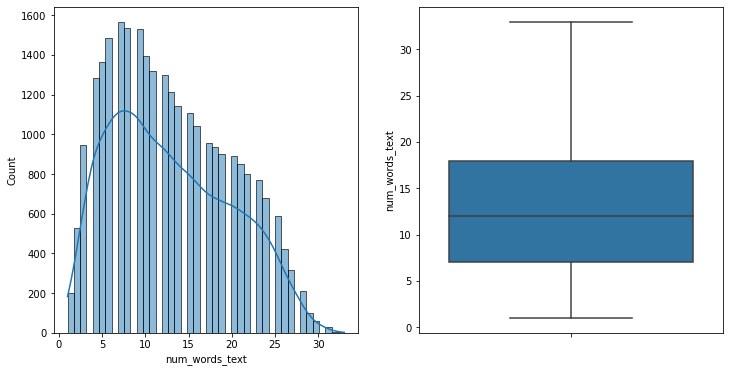

In [24]:
plot_df(df, 'num_words_text')

Observations:
- Histogram shows shape of the distribution:
1. This plot shows that the distribution of 'num_words_text' is approx. normal.
2. Distribution is right skewed.
3. It has only one mode.
4. Most of the tweets (mean) have 10 words only.
5. Median is greater than mode.

- Boxplot defines the exact value for the statistcs:
1. Boxplot shows 75% of the tweets have word length less than or equal to 18.
2. First quartile is much less than the fourth quartile

In [25]:
df[df['num_words_text'] < 5 ]['score'].mean()

0.8192454954954955

For number of words in a tweet < 5, It is very intersting to note that the tweets have 0.82 as average jaccard similarity score, which means that the tweet and selected text are very similar.

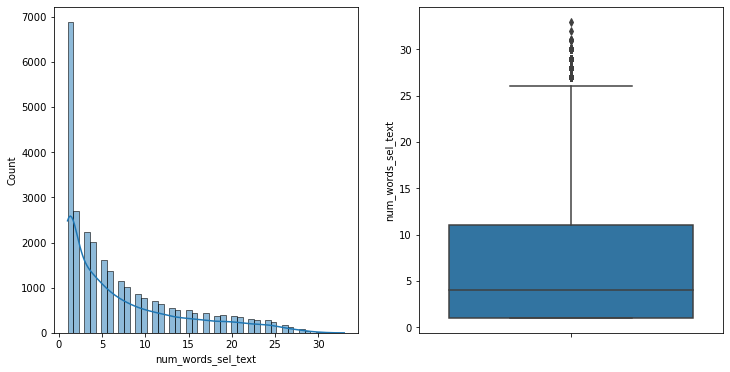

In [26]:
plot_df(df, 'num_words_sel_text')

Observations:
- Histogram shows shape of the distribution:
1. This plot shows that the distribution of 'num_words_sel_text' is approx. normal.
2. Distribution is highly right skewed.
3. It has only one mode.
4. Most of the selected text (mean) have around 7 words only.
5. Median is greater than mode.

- Boxplot defines the exact value for the statistcs:
1. Boxplot shows 75% of the tweets have word length less than or equal to 11.
2. First quartile is much less than the fourth quartile.
3. It shows that there are some outliers, which have word lengths even greater than 30.

In [27]:
df[df['num_words_sel_text'] > 10 ]['sentiment'].value_counts()

neutral     5739
negative     581
positive     565
Name: sentiment, dtype: int64

For number of words in selected text > 10, It is very intersting to note that the tweets with neutral sentiments are <b> more than 83% </b> of the total tweets.

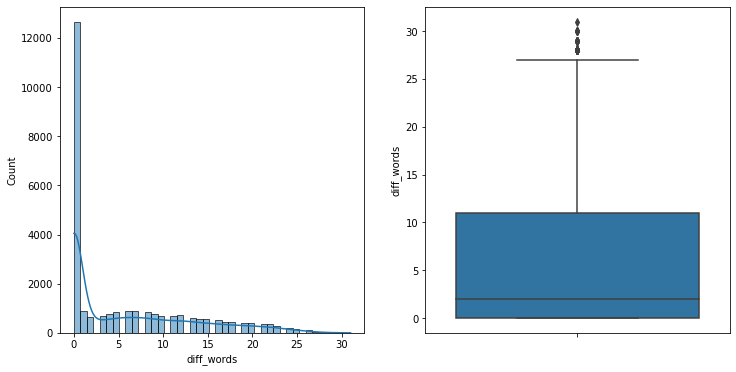

In [28]:
plot_df(df, 'diff_words')

Observations:
- Histogram shows shape of the distribution:
1. This plot shows that the distribution of 'diff_words' is approx. normal.
2. Distribution is right skewed.
3. It has only one mode.
4. Mostly difference between the number of words in a tweet and selected text (mean) is less than 8 words.
5. Median is greater than mode.

- Boxplot defines the exact value for the statistcs:
1. Boxplot shows 75% of the difference between the number of words in a tweet and selected text is less than or equal to 11.
2. First quartile is much less than the fourth quartile
3. It shows that there are some outliers, which have difference between the number of words in a tweet and selected text is even greater than 30.

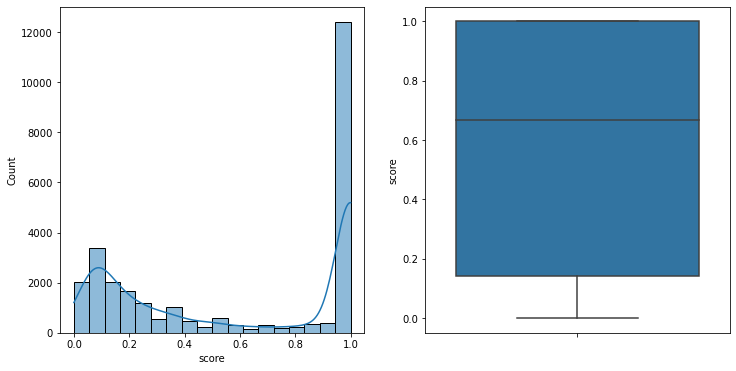

In [29]:
plot_df(df, 'score')

Observations:
- Histogram shows shape of the distribution:
1. It has only two modes, bimodal distribution.
2. The mean jaccard score is around 0.5.
3. It shows that the number of tweets which have 0.1 and 1 as jaccard score is much more than other tweets.
4. Hence there are many tweets which has same words as selected text.

In [30]:
df[df['score'] == 1]['sentiment'].value_counts()

neutral     10012
negative     1143
positive     1124
Name: sentiment, dtype: int64

For instance with score equal to 1, It is very intersting to note that more than 81% belongs to the neutral sentiment.

In [31]:
df[df['score'] <= 0.2]['sentiment'].value_counts()

positive    4881
negative    4020
neutral       31
Name: sentiment, dtype: int64

For instance with score less than equal to 0.2, It is very intersting to note that more than 99% instances belongs to the positive and negative sentiments.

### Flaws in the dataset

In [32]:
df[(df['score'] == 0)].head()

,text,selected_text,sentiment,num_words_text,num_words_sel_text,diff_words,score
18,is back home now gonna miss every one,onna,negative,8,1,7,0.0
64,mannnn..... _ got an iphone!!! im jealous.... ...,jealous..,negative,8,1,7,0.0
66,He`s awesome... Have you worked with him bef...,s awesome,positive,12,2,10,0.0
102,"1 week post my'horrible, traumatic jumping cho...","horrible,",negative,19,1,18,0.0
116,graduation is done im a little sad.. anyone w...,sad.,negative,12,1,11,0.0


In [33]:
print('Total Instances: {}'.format(len(df[(df['score'] == 0)])))

Total Instances: 572


It shows that the dataset has some flaws!

The above results can be verified by cleaning our texts.

### Feature Engineering with Text Preprocessing

In [16]:
stop_words = stopwords.words('english') #English language's stop words

def textpreprocess(s):
    """This function cleans the text
    Input: string to be cleaned
    Return: string after cleaning
    """
    words = [] # empty list
    
    s = s.strip().lower() # lower the string
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
    
    words = s.split() # split the string into list of words
    words = [word for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    
    return s

Note: The text preprocessing techniques, such as removing stop words, symbols, extra spaces, URLs, etc., are only be used for the exploratory data analysis. As the prediction can have these words in it so we will not use text preprocessing for the input of the model.

In [34]:
df_processed = dataframe_process(orig_df, is_textpre = True)
df_processed.head()

,text,selected_text,sentiment,num_words_text,num_words_sel_text,diff_words,score
0,id responded going,id responded going,neutral,3,3,0,1.000000
1,sooo sad miss san diego,sooo sad,negative,5,2,3,0.400000
2,boss bullying,bullying,negative,2,1,1,0.500000
3,interview leave alone,leave alone,negative,3,2,1,0.666667
4,sons couldnt put releases already bought,sons,negative,6,1,5,0.166667


In [35]:
df_processed[df_processed['score'].isnull()].head()

,text,selected_text,sentiment,num_words_text,num_words_sel_text,diff_words,score
8,,,neutral,0,0,0,NaN
328,,,neutral,0,0,0,NaN
641,,,neutral,0,0,0,NaN
1270,,,neutral,0,0,0,NaN
1385,,,neutral,0,0,0,NaN


The score is nan because the tweet and selected text are removed in text preprocessing.

In [36]:
df_processed.dropna(inplace=True) # Drop the instances with nan score

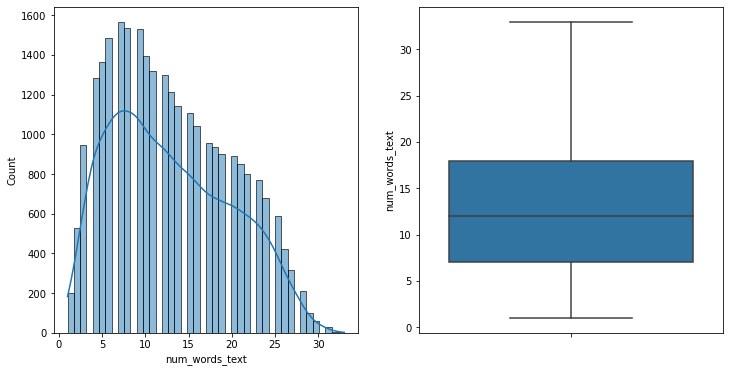

In [37]:
plot_df(df_processed, 'num_words_text') # statistical analysis after cleaning the dataset

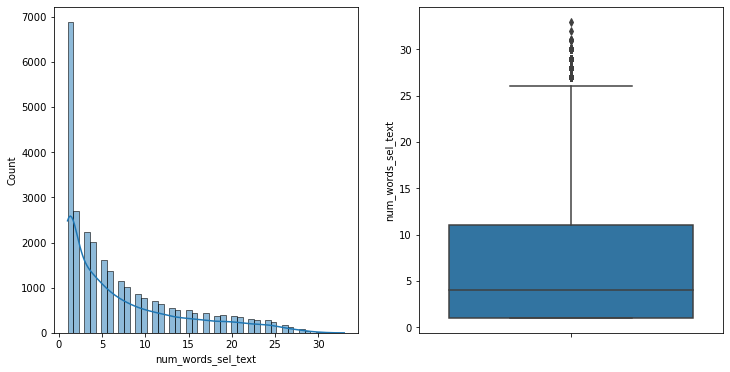

In [38]:
plot_df(df_processed, 'num_words_sel_text')

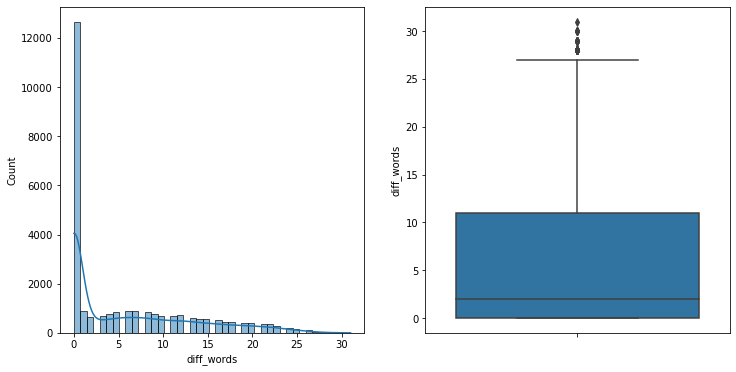

In [39]:
plot_df(df_processed, 'diff_words')

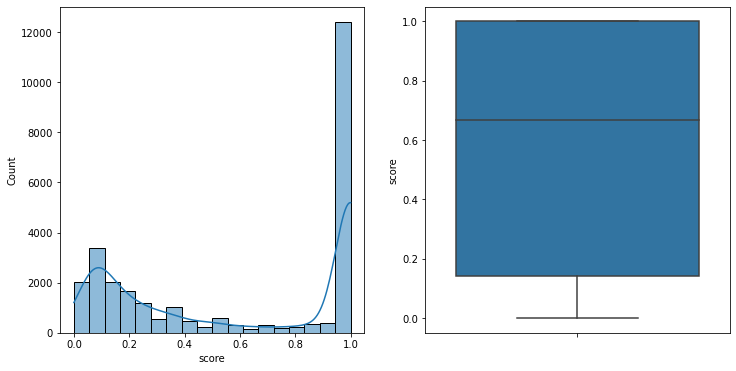

In [40]:
plot_df(df_processed, 'score')

### Creating dataframe for each sentiment value

In [41]:
df_negative = df_processed.loc[df_processed['sentiment'] == 'negative']
df_positive = df_processed.loc[df_processed['sentiment'] == 'positive']
df_neutral = df_processed.loc[df_processed['sentiment'] == 'neutral']

In [42]:
def multi_kde_plot(df_list, feature):
    """This function plots multiple distributions in a single plot.
    Input: DataFrame list
    Return: Nothing
    """
    
    plt.figure(figsize= (12, 6))
    sns.kdeplot(x = feature, data =df_list[0], label = 'Negative', color= 'r', shade=True)
    sns.kdeplot(x = feature, data =df_list[1], label = 'Positive', color= 'g', shade=True)
    sns.kdeplot(x = feature, data =df_list[2], label = 'Neutral', color= 'b', shade=True)
    plt.legend()
    plt.show()

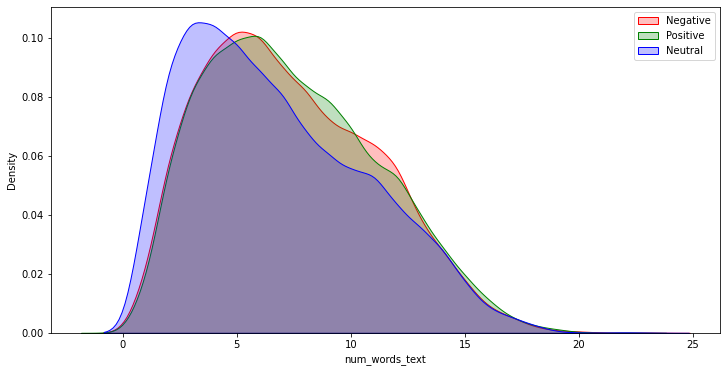

In [43]:
multi_kde_plot([df_negative, df_positive, df_neutral], 'num_words_text')

Observation:
1. The above plot shows that the distribution is approx normal for all three categories
2. Mean number of words in a tweet with sentiment as neutral are less than the tweets with other sentiments

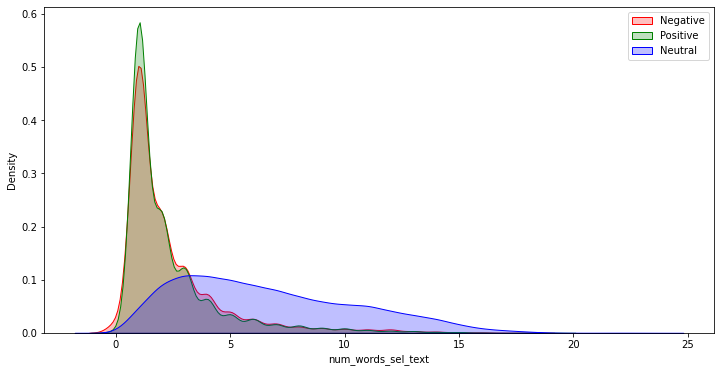

In [44]:
multi_kde_plot([df_negative, df_positive, df_neutral], 'num_words_sel_text')

Observation:
1. Number of words in a selected text with sentiment as neutral is higher than other categories.

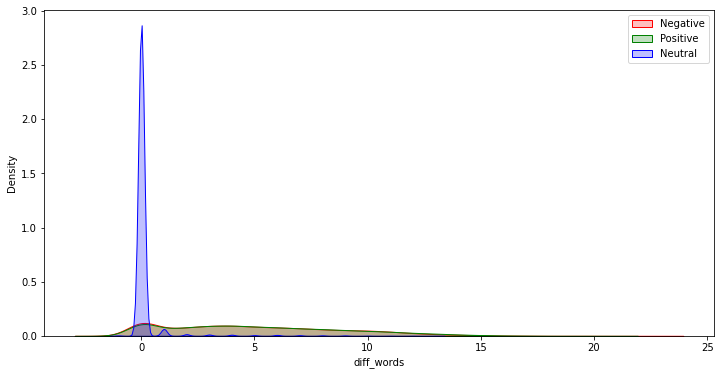

In [45]:
multi_kde_plot([df_negative, df_positive, df_neutral], 'diff_words')

 The peak at 0 for neutral sentiments shows that the number of words in a tweet is same as the number of words in the selected text.

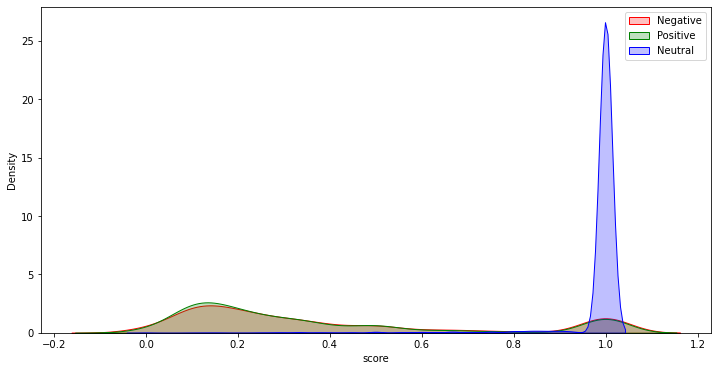

In [46]:
multi_kde_plot([df_negative, df_positive, df_neutral], 'score')

The peak at 1 for neutral sentiments shows that the number of words in a tweet is same as the number of words in the selected text.

## Word cloud

In [47]:
def top_words(df_tmp, feature, num_top = 20):
    """This function finds the frequent words in a dataframe for a given feature
    Input:
    1. Dataframe,
    2. feature,
    3. num_top: how many top frequent words you want
    
    Return: A datframe with words and their count"""
    
    words = []
    top_words_df = pd.Series([], dtype= 'object') # creating empty data series
    
    if feature == 'text':
        i = 0
    else:
        i = 1
        
    for row in df_tmp.iterrows(): # iterating through rows
        words.append(row[1][i].split())
        
    words = list(np.concatenate(words).flat) # list containg all words
    top_words_df = pd.DataFrame(words).value_counts().rename_axis('words')[:num_top].reset_index(name = 'count')
#     top_words_df.columns = ['word', 'count']
    
    return top_words_df

### Frequent words in negative tweets

In [48]:
neg_top = top_words(df_negative, 'selected_text')
neg_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,im,452
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162


### Frequent words in positive tweets

In [49]:
pos_top = top_words(df_positive, 'selected_text')
pos_top.head(10).style.background_gradient(cmap='Greens')

,words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


### Frequent words in neutral tweets

In [50]:
neut_top = top_words(df_neutral, 'selected_text')
neut_top.head(10).style.background_gradient(cmap='Blues')

,words,count
0,im,1039
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427


In [51]:
def plot_wordcloud(df_tmp):
    """This function plots word cloud
    Input: Dataframe with words and their count
    Returns: Nothing"""
    
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df_tmp['words'].tolist()))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Word cloud for negative tweets

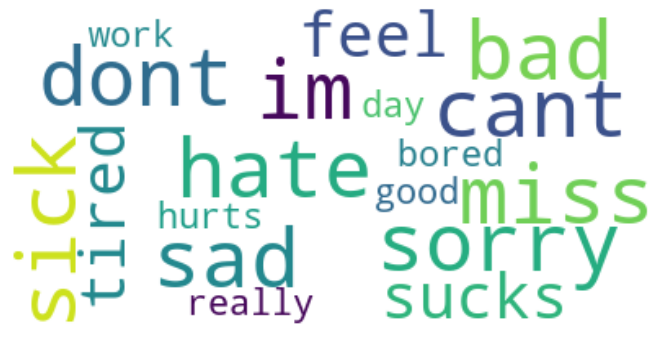

In [52]:
plot_wordcloud(neg_top)

### Word cloud for positive tweets

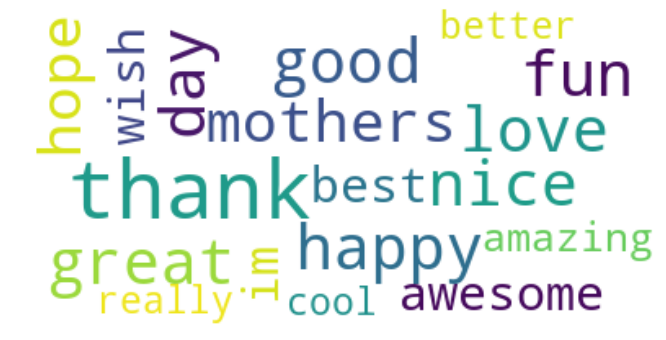

In [53]:
plot_wordcloud(pos_top)

### Word cloud for neutral tweets

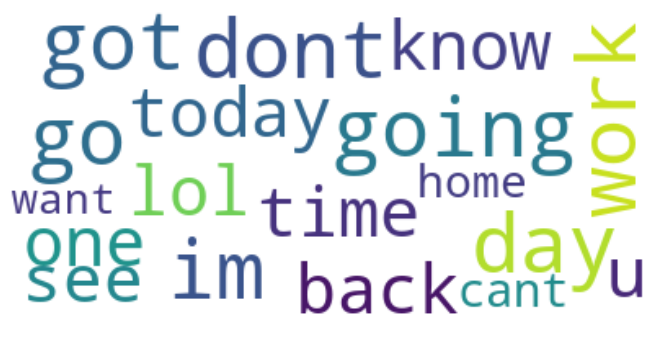

In [54]:
plot_wordcloud(neut_top)

## Modeling Approaches

Sequence Models like LSTM have transformed speech recognition, natural language processing, and other areas, and in this project, we are using the sequence models, such as Long-short term memory (LSTM), and bidirectional LSTM. 

But our dataset consists of tweets in the English language which can be easily understood by humans, but we need to convert these tweets (text) into some suitable form that can be understood by the machines. There are different methods/techniques available to perform this task such as the bag of words, tf-idf, word embeddings, etc. For this project, we will be using the word embeddings instead of the bag of words and tf-idf, and the reason for this selection is that in the case of the bag of words and tf-idf techniques the contextual meaning of the sentence gets lost.

As we know that we have to predict the specific part of the given tweet based on its sentiment, we will try to solve this as a <b> sequence-to-sequence </b> problem i.e., we assume our input(text) as a sequence of words and the output as 0 or 1 for the corresponding input word at each time steps (1 if the input word is responsible for sentiment, otherwise 0). 

For example:

Input: 		My ridiculous dog is amazing. & [Sentiment : positive]

Output : 	0     0       0    0     1

### Splitting data into Independent and Dependent features for each sentiment value

In [55]:
def make_xy(df_tmp):
    """This function splts the data into Independent and Dependent features based on the sentiment
    Input: DataFrame
    Return: Independent and Dependent features"""
    
    x_tmp = [] # empty list for Independent features
    y_tmp = [] # empty list for Dependent features
    for u in df_tmp['sentiment'].unique(): # looping through each sentiment value
        x_tmp.append(df_tmp[df_tmp['sentiment'] == u]['text'].tolist())
        y_tmp.append(df_tmp[df_tmp['sentiment'] == u]['selected_text'].tolist())
        
    return x_tmp, y_tmp
        

In [56]:
x, y = make_xy(df)

In [57]:
x_neut, x_neg, x_pos = x[0], x[1], x[2] # Independent features
y_neut, y_neg, y_pos = y[0], y[1], y[2] # Dependent features

### Splitting dataset into train and test dataset

In [58]:
def split(x_tmp, y_tmp, test_size):
    """ This function splits dataset into train and test dataset
    Input: Independent, Dependent features and test size
    Return: Independent and Dependent features for train and test dataset"""
    
    x_train, x_test, y_train, y_test = train_test_split(x_tmp, y_tmp, test_size=test_size, random_state=42)
    
    return x_train, x_test, y_train, y_test

In [59]:
x_neg_train, x_neg_test, y_neg_train, y_neg_test = split(x_neg, y_neg, test_size = 0.2)

In [60]:
x_neut_train, x_neut_test, y_neut_train, y_neut_test = split(x_neut, y_neut, test_size = 0.2)

In [61]:
x_pos_train, x_pos_test, y_pos_train, y_pos_test = split(x_pos, y_pos, test_size = 0.2)

### Tokenizing and Padding

Text is tokenized and padded so that the it becomes compatible with model input requirements

In [62]:
# hyperparameters
vocab_size = 30000
embedding_dim = 256
max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [63]:
def y_pad(x_sequences, y_sequences):
    """This function is used to generate padded y sequence, 
    assuming that our input(text) is a sequence of words and 
    the output as 0 or 1 for the corresponding input word at
    each time steps (1 if the input word is responsible for sentiment, otherwise 0).  """
    
    index = []
    y_pad_seq = []
    
    for i in range(len(x_sequences)): # iterating through each x_sequence
        t = x_sequences[i] # tweet
        st = y_sequences[i] # selected text
        l_t = len(t) # length of tweet
        l_st = len(st) # length of selected text
        n = l_t - l_st + 1 # number of times selected text will be looked up in tweet
        st_new  = np.zeros(max_length) # creating a zero array of size same as x_pad
        
        for j in range(0, n):
            if st == t[j : j + l_st]: # selected text == part of tweet at index [j : j + l_st]
                st_new[j : j+l_st] = 1 # replace 0 by 1
                y_pad_seq.append(st_new) 
                index.append(i)
                break
        
    return np.array(y_pad_seq), np.array(index)

In [64]:
def token(x_train, x_test, y_train, y_test):
    """This function is used to tokenize and padding the tweet and selected text"""
    
    tokenizer = Tokenizer(num_words= vocab_size, oov_token= oov_tok)
    tokenizer.fit_on_texts(x_train)
    word_index = tokenizer.word_index
    
    x_train_sequences = tokenizer.texts_to_sequences(x_train)
    x_train_pad_sequences = pad_sequences(x_train_sequences, maxlen= max_length, truncating= trunc_type, padding=padding_type)
    
    x_test_sequences = tokenizer.texts_to_sequences(x_test)
    x_test_pad_sequences = pad_sequences(x_test_sequences, maxlen= max_length, truncating= trunc_type, padding=padding_type)
    
    y_train_sequences = tokenizer.texts_to_sequences(y_train)
    y_train_pad_sequences, y_train_index = y_pad(x_train_sequences, y_train_sequences) # y_train_index is used to drop thos instances where the selected text is not present in the tweet.
    
    
    y_test_sequences = tokenizer.texts_to_sequences(y_test)
    y_test_pad_sequences, y_test_index = y_pad(x_test_sequences, y_test_sequences)
    
    return x_train_pad_sequences[y_train_index], x_test_pad_sequences[y_test_index], y_train_sequences, y_train_pad_sequences, y_test_sequences, y_test_pad_sequences, word_index

In [65]:
x_neg_train_pad_sequences, x_neg_test_pad_sequences, y_neg_train_sequences, y_neg_train_pad_sequences, y_neg_test_sequences, y_neg_test_pad_sequences, neg_word_index = token(x_neg_train, x_neg_test, y_neg_train, y_neg_test)

In [66]:
x_neut_train_pad_sequences, x_neut_test_pad_sequences, y_neut_train_sequences, y_neut_train_pad_sequences, y_neut_test_sequences, y_neut_test_pad_sequences, neut_word_index = token(x_neut_train, x_neut_test, y_neut_train, y_neut_test)

In [67]:
x_pos_train_pad_sequences, x_pos_test_pad_sequences, y_pos_train_sequences, y_pos_train_pad_sequences, y_pos_test_sequences, y_pos_test_pad_sequences, pos_word_index = token(x_pos_train, x_pos_test, y_pos_train, y_pos_test)

### Examples after tokenization and padding

In [68]:
x_neg_train_pad_sequences[0] # tweet after tokenization and padding

array([   2,   43,   10,   69,    4, 3930, 2609,    9,  160,   19,   13,
        263,    2,   17,  212,    7,  216,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [69]:
y_neg_test_pad_sequences[0] # Selected text after tokenization and padding

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

### Building Model

<b> RNN: </b>
Recurrent neural networks, or RNNs, are a type of artificial neural network that add additional weights to the network to create cycles in the network graph to maintain an internal state.

Weakness of RNN:
1.	RNN tends to gradients vanishing, so it becomes difficult to update the parameters of RNN based on the longer dependencies. But in English sentences, we may have very long dependencies.
2.	Prediction at t only depends on the previous cells/inputs.

<b> LSTM: </b>
LSTM can solve the problem of RNN i.e shorter dependencies, by providing a memory cell to keep the context till it is required.

Weakness of LSTM:
1.	Though LSTM helped in longer dependencies, even now the prediction at t, only depends on the previous cells/inputs and not on the next inputs.




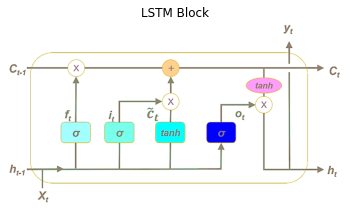

In [66]:
image(path=r'C:\Users\14372\Desktop\College-2\CAPstone\PROJECT\LSTM block.png', title='LSTM Block')

<b>Bidirectional LSTM:</b>
To overcome the weakness of LSTM, we will use bidirectional LSTM, in which the cell state can be used at any block.

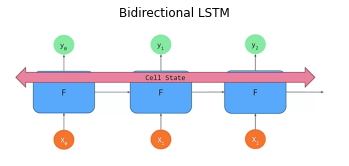

In [67]:
image(path=r'C:\Users\14372\Desktop\College-2\CAPstone\PROJECT\Bidirectional LSTM.png', title='Bidirectional LSTM')

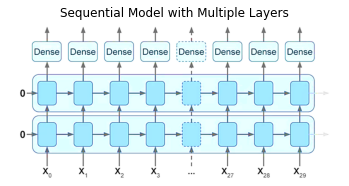

In [68]:
image(path=r'C:\Users\14372\Desktop\College-2\CAPstone\PROJECT\Sequential Model.png', title='Sequential Model with Multiple Layers')

### Training Model

In [70]:
def plot_graphs(history, string):
    """To plot the loss and metrics for a trained model."""
    
    plt.plot(history.history[string]) # To plot the metrics for training data
    plt.plot(history.history['val_'+string]) # To plot the metrics for validation data
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [117]:
def build_model(x_train_tmp, y_train_tmp, x_test_tmp, y_test_tmp, model_type, batchSize = 128, Epochs = 100):

    model = Sequential([
        Embedding(
            vocab_size,
            embedding_dim,
            input_length=max_length
        ), # to convert tokenize sequence to word embeddings

        Conv1D(256, 1, activation='relu'), # 1d convolutional layer

        Bidirectional(
            LSTM(256,
            return_sequences=True,
            kernel_regularizer=l2(0.01))
            ), # bidirectional lstm with kernel regualizer to prevent overfitting

        Bidirectional(
            LSTM(128, 
            return_sequences=True, 
            kernel_regularizer=l2(0.01))
        ), # bidirectional lstm with kernel regualizer to prevent overfitting

        Dropout(0.4), # Dropout layer to prevent overfitting

        TimeDistributed(Dense(128, activation='relu')), # Time Distributed Dense layer 
        Dropout(0.4),
        TimeDistributed(Dense(64, activation='relu')),# Time Distributed Dense layer 
        Dropout(0.2),
        TimeDistributed(Dense(1, activation='sigmoid'))# Time Distributed Dense layer 
    ])
    
    print('Training model for {} tweets'.format(model_type))
    print(model.summary())
    
    adam = Adam(lr=0.01) # Adam optimizer
    model.compile(loss = 'binary_crossentropy', # binary crossentropy loss
              optimizer=adam, 
              metrics=['accuracy'])
    
    history = model.fit(
    x = x_train_tmp,
    y = y_train_tmp, epochs=Epochs,
    validation_data= (x_test_tmp, y_test_tmp),
    batch_size = batchSize)
    
    name = 'model_{}'.format(model_type)
    model.save(name + '.h5')
    
    plot_graphs(history, 'accuracy')
    plt.show()
    plot_graphs(history, 'loss')
    plt.show()

### Training Model for negative tweets

Training model for negative tweets
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 256)           7680000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 40, 256)           65792     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 40, 512)           1050624   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 40, 256)           656384    
_________________________________________________________________
dropout_14 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
time_distributed_12 (TimeDis (None, 40, 128)           32896     
_________________________________________________________________
dropout_15 (Dropout

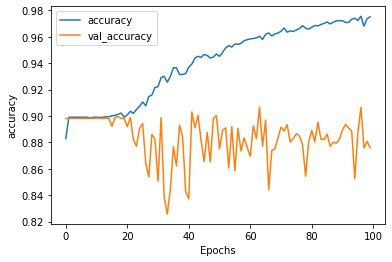

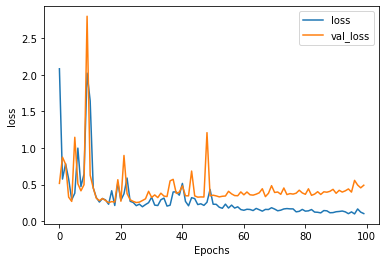

In [118]:
build_model(x_neg_train_pad_sequences, y_neg_train_pad_sequences, x_neg_test_pad_sequences, y_neg_test_pad_sequences, batchSize = 128, Epochs = 100, model_type = 'negative')

### Training Model for neutral tweets

Training model for neutral tweets
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 256)           7680000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 40, 256)           65792     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 40, 512)           1050624   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 40, 256)           656384    
_________________________________________________________________
dropout_17 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 40, 128)           32896     
_________________________________________________________________
dropout_18 (Dropout)

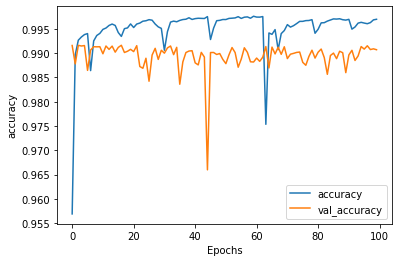

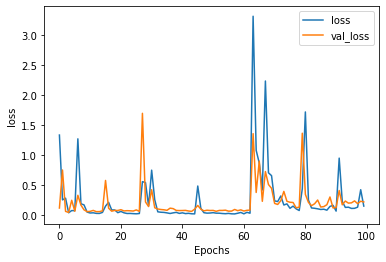

In [125]:
build_model(x_neut_train_pad_sequences, y_neut_train_pad_sequences, x_neut_test_pad_sequences, y_neut_test_pad_sequences, batchSize = 128, Epochs = 100, model_type = 'neutral')

### Training Model for positive tweets

Training model for positive tweets
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 256)           7680000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 40, 256)           65792     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 40, 512)           1050624   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 40, 256)           656384    
_________________________________________________________________
dropout_20 (Dropout)         (None, 40, 256)           0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 40, 128)           32896     
_________________________________________________________________
dropout_21 (Dropout

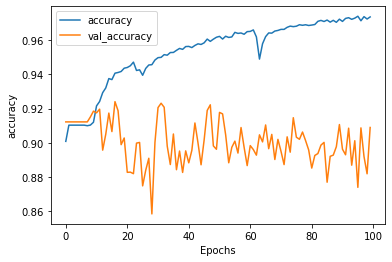

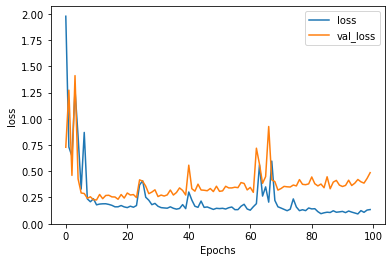

In [126]:
build_model(x_pos_train_pad_sequences, y_pos_train_pad_sequences, x_pos_test_pad_sequences, y_pos_test_pad_sequences, batchSize = 128, Epochs = 100, model_type = 'positive')

Observations:
1. The upper graphs show that there is a difference between training and validation metric which is a sign of overfitting.
2. Validation loss increased while the validation accurace is approx. same, it shows that model is not confident with its prediction.

### Prediction

In [72]:
model_negative = load_model('model_negative.h5')
model_positive = load_model('model_positive.h5')
model_neutral = load_model('model_neutral.h5')

In [73]:
def reverse_index(index_lst):
    """This function returns a string for a tokenize sequence
    Input: tokenize sequence
    Return: string
    """
    word_lst = [] # empty list for words
    reverse_word_index = dict([(index, word) for (word, index) in neg_word_index.items()])
    for i in index_lst:
        word_lst.append(reverse_word_index.get(i, '?'))
        
    return ' '.join(word_lst)

In [74]:
def results(model, x_test_tmp, y_test_tmp, show = 5):
    """This funtion helps to print the result in the form of dataframe"""
    
    data = dict()
    x_ = []
    y_actual = []
    y_prediction = []
    
    y_p = model.predict(x_test_tmp)
    y_p = y_p >= 0.5
    mask = np.random.choice(a = np.arange(0, y_p.shape[0]), size = show)
#     print(mask)

    for i in mask:
        x_.append(reverse_index(x_test_tmp[i]))
        y_actual.append(reverse_index(x_test_tmp[i][(y_test_tmp[i]).astype('bool')]))
        y_prediction.append(reverse_index(x_test_tmp[i][y_p[0].ravel()]))
        
    data = {'text': x_, 
           'actual_selected_text': y_actual,
           'pred_selected_text': y_prediction}
    
    return pd.DataFrame(data)

In [143]:
results(model_neutral, x_neut_test_pad_sequences, y_neut_test_pad_sequences)

,text,actual_selected_text,pred_selected_text
0,last ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?...,last,last ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
1,<OOV> i no very leave waiting for ? ? ? ? ? ? ...,<OOV> i no very leave waiting for,<OOV> i no very leave waiting for ? ? ? ? ? ? ...
2,myspace for in knew the join called bush s it ...,myspace for in knew the join called bush s it ...,myspace for in knew the join called bush s it ...
3,in a hate watch to wedding s my realy to <OOV>...,in a hate watch to wedding s my realy to <OOV>...,in a hate watch to wedding s my realy to <OOV>...
4,thought the ohh this have and ? ? ? ? ? ? ? ? ...,thought the ohh this have and,thought the ohh this have and ? ? ? ? ? ? ? ? ...


In [135]:
results(model_negative, x_neg_test_pad_sequences, y_neg_test_pad_sequences)

,text,actual_selected_text,pred_selected_text
0,have a huge headache don t have <OOV> here at ...,have a huge headache don t have <OOV> here at ...,have a
1,stuck in stupid <OOV> with <OOV> up wish i was...,stuck in stupid,stuck in
2,feeling lonely and in need a a good friend ? ?...,feeling lonely and in need a a good friend,feeling lonely
3,not helping ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ...,not helping,not helping
4,decided i should study finger down throat maki...,hate,decided i


## References:
1. We acquire the data from the following source:
- Kaggle: https://www.kaggle.com/c/tweet-sentiment-extraction/data?select=train.csv. This dataset is taken from the twitter sentiment extraction competition on Kaggle. 